## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# Содержание <a id='0.0'></a>

<div style="border:solid blue 2px; padding: 20px">
    
<font color='blue'>
<a href='#1.1'>1. Подготовка данных'</a>

<a href='#1.2'>2. Анализ'</a>

 - <a href='#1.3'>2.1 Анализ временного ряда'</a>
 - <a href='#1.4'>2.2 Создание признаков'</a>
 - <a href='#1.5'>2.3 Определение корреляции'</a>

<a href='#1.6'>3. Обучение и подбор гиперпараметров'</a>

 - <a href='#1.7'>3.1 Разделение выборки и подготовка к обучению'</a>
 - <a href='#1.8'>3.2 Подбор гиперпараметров'</a>


<a href='#1.9'>3. Тестирование'</a>

<a href='#2.0'>4. Выводы'</a>


# 1. Подготовка <a id='1.1'></a>

In [805]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy as sp
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings("ignore")
# Импортируем необходимые библиотеки.

In [806]:
# чтение файла. Просмотрим общий вид таблиц и инфу по файлу, а так же наличие пропусков.
#taxi = pd.read_csv('/Users/kazbek/Desktop/Python/Payton/DS - обучение/Курс 9_Времяные ряды/taxi.csv',index_col=[0], parse_dates=[0])
taxi = pd.read_csv('/datasets/taxi.csv')
display(taxi.head())
display(taxi.info())
display(taxi.isna().sum())
# Методом describe выводим статистические показатели числовых столбцов
taxi.describe()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

num_orders    0
dtype: int64

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


<div style="border:solid gray 2px; padding: 20px">
    
<font color='brown'>В ходе чтения файла имеет слудующие данные:
- Временной ряд от 2018-03-01 00:00:00 до 2018-08-31 23:50:00, то есть с начала марта по конец августа 2018 года. Это говорит о том, что мы не сможем увидеть тренд в зависимости от времени года, однако должны определить тренд по месяцам.
- 26496 записей, показывающих число заказов такси в 10 минутные промежутки времени и 1 столбец.
- тип данных целочисленный.
- пропусков нет.
- дубликаты смотреть нет смысла так, как всего один столбец с повтояющимися значениями.
- статистические показатели показали, что ьаксимальное значение 119 заказов и минимальное значение 0, стандартное отклонение 9 заказов и среднее 14 заказов. Видно, что есть выбросы в наших данных( 119 заказов за 10 минут слишком фантастически, учитывая среднее значение и стандартное отклонение. 

In [807]:
#выполним ресемплирование так, чтобы наши данные сагрегировались по часам и по дням
taxi.sort_index(inplace=True)
taxi_day = taxi.resample('1D').sum()
taxi_hour = taxi.resample('1H').sum()

In [808]:
#Посмотрим, что у нас получилось
display(taxi_hour.head())
display(taxi_hour.info())

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


None

<div style="border:solid gray 2px; padding: 20px">
    
<font color='brown'>Наш горизонт прогнозирования равен одному часу. Нам нужно предсказывать данные на следущий час, поэтому выполнили ресемплирование так, чтобы наши данные сагрегировались по часам (количество записей в датасете уменьшились до 4416). Ресемплирование по дням нужно для проведения анализа временных рядов.

<a href='#0.0'>Содержание'</a>

# 2. Анализ <a id='1.2'></a>

### 2.1 Анализ временного ряда <a id='1.3'></a>

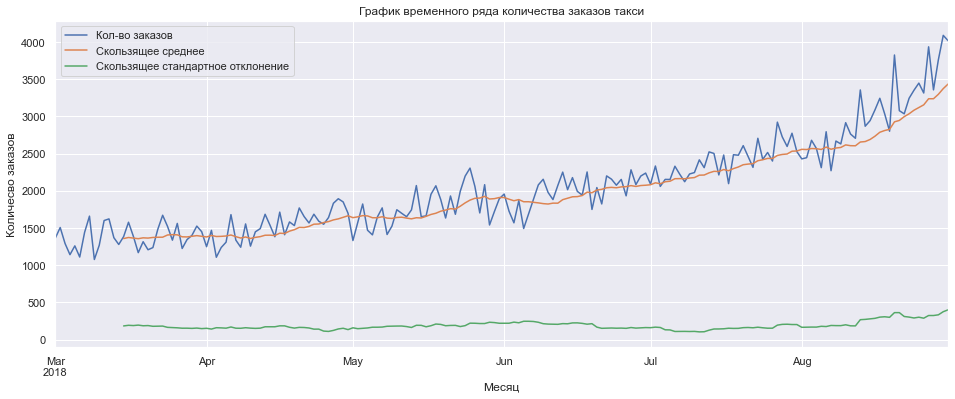

In [809]:
# Посмотрим на графике временной ряд количества заказов такси сагрегированный по дням.
# Так же найдем Скользящее среднее и Скользящее стандартное отклонение методом rolling()
taxi_day['num_orders'].plot(figsize=(16,6))
taxi_day['num_orders'].rolling(15).mean().plot()
taxi_day['num_orders'].rolling(15).std().plot()
plt.legend(labels=['Кол-во заказов','Скользящее среднее','Скользящее стандартное отклонение'])
plt.xlabel('Месяц')
plt.ylabel('Количесво заказов')
plt.title('График временного ряда количества заказов такси');

<div style="border:solid gray 2px; padding: 20px">
    
<font color='brown'>По дневному скользящему среднему можно заметить, что в данных наблюдается тренд. Скользящее среднее значение количества заказов такси постепенно увеличивается. Это говорит о том, что ряд нестационарен. Нестационарные ряды прогнозировать сложнее: их свойства меняются слишком быстро.

In [810]:
# Для того чтобы исследовать временной ряд подробнее выполним декомпозицию данных с помошью функции seasonal_decompose()
decomposed_day = seasonal_decompose(taxi_day)
decomposed_hour = seasonal_decompose(taxi_hour)

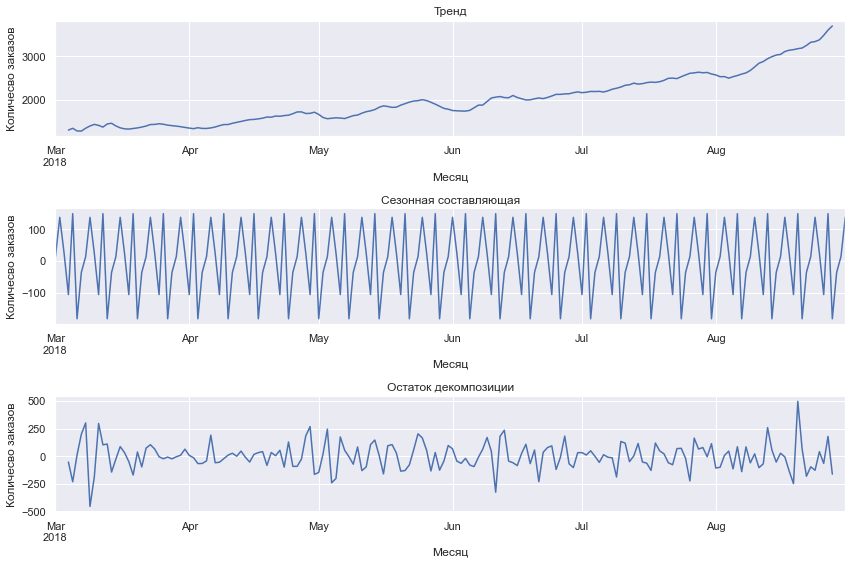

In [811]:
# Постройте график сезонной составляющей за первые 15 дней января 2018 года - Разложим временной ряд на состовляющие
plt.figure(figsize=(12, 8))
plt.subplot(311)
decomposed_day.trend.plot(ax=plt.gca())
plt.xlabel('Месяц')
plt.ylabel('Количесво заказов')
plt.title('Тренд')
plt.subplot(312)
decomposed_day.seasonal.plot(ax=plt.gca())
plt.xlabel('Месяц')
plt.ylabel('Количесво заказов')
plt.title('Сезонная составляющая')
plt.subplot(313)
decomposed_day.resid.plot(ax=plt.gca())
plt.xlabel('Месяц')
plt.ylabel('Количесво заказов')
plt.title('Остаток декомпозиции')
plt.tight_layout()

<div style="border:solid gray 2px; padding: 20px">
    
<font color='brown'>График имеет тренд на повышение - это может быть, как годовая сезонность, так и рост числа заказов из-за увеличения количества клиентов(компания привлекла больше клиентов в связи с увеличением автопарка, либо проведения акций или увеличения расходов на рекламу, т.е. не за счет сезонности. Отчетливо прослеживается сезонная зависимость количества заказов от дня недели.

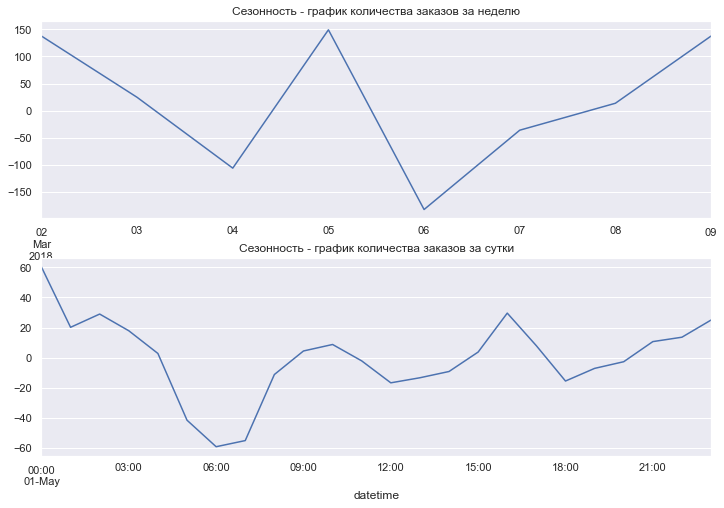

In [812]:
#Посмотрим на статистику заказов в разбивке по дням за неделю
plt.figure(figsize=(12, 8))
plt.subplot(211)
plt.title("Сезонность - график количества заказов за неделю")
ax = decomposed_day.seasonal['2018-03-02':'2018-03-09'].plot(ax=plt.gca())
#И на статистику заказов в разбивке по часам за один день
plt.subplot(212)
plt.title("Сезонность - график количества заказов за сутки")
ax = decomposed_hour.seasonal['2018-05-01':'2018-05-01'].plot(ax=plt.gca())

<div style="border:solid gray 2px; padding: 20px">
    
<font color='brown'>Как видим у нас есть сезонная составляющая:
- В течении недели: С понедельника по вторник наблюдается спад заказов, в среду наблюдаем рост заказов, в четверг снова спад заказов и с пятницы по воскресенье наблюдается рост заказов. Всего 4 взлета и падения.
- В течении суток: С 12 ночи до 6 утра видим спад заказов, с 6 утра до 10 утра рост заказов, затем до 12 дня падение числа заказов и с 12 часов до 16 идет рост, с 16 до 18 - падение и с 18 до 12 часов снова рост заказов. Всего 6 падение и взлетов.

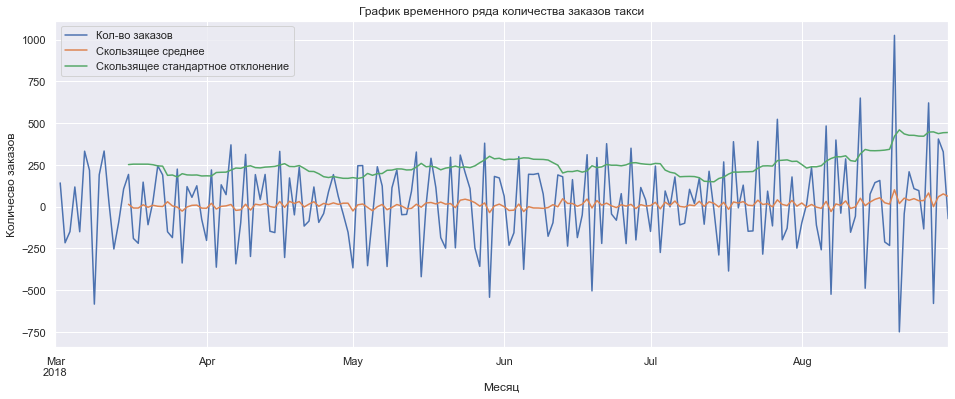

In [813]:
# Стохастический процесс не стационарный.Чтобы ряд сделать стационарным, найдём разности его значений методом shift()
taxi_day = taxi_day - taxi_day.shift()
taxi_day['mean'] = taxi_day['num_orders'].rolling(15).mean()
taxi_day['std'] = taxi_day['num_orders'].rolling(15).std()
taxi_day.plot(figsize=(16,6))
plt.legend(labels=['Кол-во заказов','Скользящее среднее','Скользящее стандартное отклонение'])
plt.xlabel('Месяц')
plt.ylabel('Количесво заказов')
plt.title('График временного ряда количества заказов такси');

<a href='#0.0'>Содержание'</a>

### 2.2 Создание признаков <a id='1.4'></a>

In [814]:
# Теперь напишем функцию для создания признаков: Календарные признаки,Отстающие значения,Скользящее среднее.
# Чтобы ряд сделать стационарным, найдём разности его значений методом shift()
def make_features(data, max_lag):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(168).mean()
    
#  задаст максимальный размер отставания = 24, и вычислим скользящее среднее с шириной окна = 168
make_features(taxi_hour,24)

In [815]:
taxi_hour = taxi_hour.dropna()
display(taxi_hour.head())
display(taxi_hour.info())

,num_orders,month,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,3,8,0,3,94.0,127.0,108.0,76.0,50.0,...,38.0,17.0,19.0,10.0,73.0,66.0,24.0,121.0,100.0,54.226190
2018-03-08 01:00:00,78,3,8,1,3,143.0,94.0,127.0,108.0,76.0,...,50.0,38.0,17.0,19.0,10.0,73.0,66.0,24.0,121.0,54.339286
2018-03-08 02:00:00,65,3,8,2,3,78.0,143.0,94.0,127.0,108.0,...,34.0,50.0,38.0,17.0,19.0,10.0,73.0,66.0,24.0,54.297619
2018-03-08 03:00:00,68,3,8,3,3,65.0,78.0,143.0,94.0,127.0,...,58.0,34.0,50.0,38.0,17.0,19.0,10.0,73.0,66.0,54.261905
2018-03-08 04:00:00,60,3,8,4,3,68.0,65.0,78.0,143.0,94.0,...,34.0,58.0,34.0,50.0,38.0,17.0,19.0,10.0,73.0,54.273810


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4248 entries, 2018-03-08 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 30 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4248 non-null   int64  
 1   month         4248 non-null   int64  
 2   day           4248 non-null   int64  
 3   hour          4248 non-null   int64  
 4   dayofweek     4248 non-null   int64  
 5   lag_1         4248 non-null   float64
 6   lag_2         4248 non-null   float64
 7   lag_3         4248 non-null   float64
 8   lag_4         4248 non-null   float64
 9   lag_5         4248 non-null   float64
 10  lag_6         4248 non-null   float64
 11  lag_7         4248 non-null   float64
 12  lag_8         4248 non-null   float64
 13  lag_9         4248 non-null   float64
 14  lag_10        4248 non-null   float64
 15  lag_11        4248 non-null   float64
 16  lag_12        4248 non-null   float64
 17  lag_13        4248 non-null

None

<div style="border:solid gray 2px; padding: 20px">
    
<font color='brown'>После проведения процедуры создания и добавления признаков мы получили:
- 4248 записей 
- 30 столбецов.
- два типа данных целочисленный и дробный.
- появившиеся пропуски были удалены.
- были созданы 4 календарных признака (месяц,день недели, день, час)
- были созданы 24 признака отстающих значений, max_lag был взят как 24 часа
- были созданы 1 признака скользящего среднего, с шириной окна = 168 (за неделю в часах)

<a href='#0.0'>Содержание'</a>

### 2.3 Определение корреляции <a id='1.5'></a>

In [816]:
# Создадим функцию, которая выводит корреляцию Пирсона между признаками и целевым признаком.
# Функция получает таблицу с нужными столбцами на входе, перебирает циклом столбцы и выводит корреляцию
from scipy.stats import pearsonr
def corr_pr(data):
    for column in data:
        if column != 'num_orders':
            correlation,p = pearsonr(data['num_orders'], data[column])
            if abs(correlation) >= 0.5:
                display('Корреляция Пирсона между num_orders и {}: {}'.format(column, correlation))
corr_pr(taxi_hour)

'Корреляция Пирсона между num_orders и month: 0.5012373007573898'

'Корреляция Пирсона между num_orders и lag_1: 0.6201352520682243'

'Корреляция Пирсона между num_orders и lag_23: 0.5533584671833802'

'Корреляция Пирсона между num_orders и lag_24: 0.6884527668158525'

'Корреляция Пирсона между num_orders и rolling_mean: 0.5535318532029375'

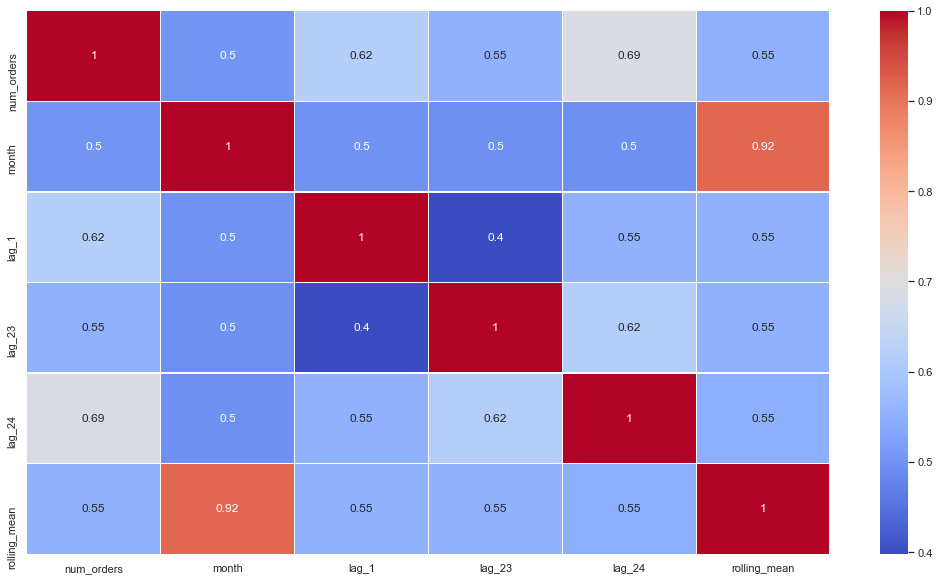

In [817]:
# Посмотрим на корреляцию числовых признаков
plt.figure(figsize=(18,10))
sns.heatmap(taxi_hour[['num_orders','month','lag_1','lag_23','lag_24','rolling_mean']].corr(),
            annot=True,cmap='coolwarm',linewidths=0.5)
plt.show()

<div style="border:solid gray 2px; padding: 20px">
    
<font color='brown'>Есть сильная положительная зависимость между столбцом lag_24,lag_1 и целевым признаком.Их можно удалить. Другие признаки имеют не сильную связь с целевым признаком. 

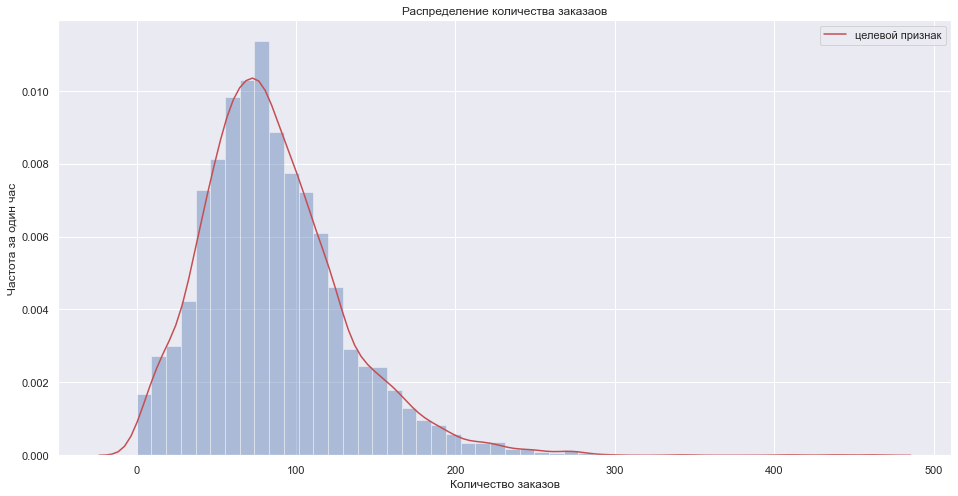

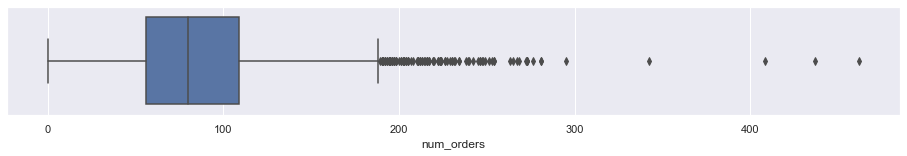

'Количество заказов  свыше 250 за час - 20'

In [818]:
# Посмотрим на распределения количества заказов. 
# Создадим график для визуального анализа распредиления
sns.set(style="darkgrid")
plt.subplots(figsize=(16,8))
ax = sns.distplot(taxi_hour['num_orders'],
                  kde_kws={"color": "r", "label": "целевой признак"})
ax.set_xlabel('Количество заказов')
ax.set_ylabel('Частота за один час')
plt.title('Распределение количества заказаов')
plt.show()

plt.figure(figsize=(16,2))
sns.boxplot(x='num_orders', data=taxi_hour)
plt.show() 
# Количество заказов свыше 250 за час
number = taxi_hour[taxi_hour['num_orders']>=250].shape[0]
display(f'Количество заказов  свыше 250 за час - {number}')

In [819]:
taxi_hour = taxi_hour.drop(['lag_1','lag_24'], axis=1)
taxi_hour = taxi_hour.query('num_orders <= 250')

<div style="border:solid gray 2px; padding: 20px">
    
<font color='brown'> Гистограмма имеет характерную форму распределения Пуассона. Наличие нулей обосновано.А вот наличие заказов больше 200 за один час - неправдаподобно, скороее всего это выбросы. Удалим коррелирующие признаки и удалим выбросы свыше 250 за час

<a href='#0.0'>Содержание'</a>

# 3. Обучение и подбор гиперпараметров <a id='1.6'></a>

### 3.1 Разделение выборки и подготовка к обучению   <a id='1.7'></a>

In [820]:
# Разделим нашу таблицу с данными на целевой признак и осальные признаки
# Разделим выборку на обучающую и тестовую часть - для модели LGBM отдельно и для остальных моделей.
train, test = train_test_split(taxi_hour, shuffle=False, test_size=0.1)
features_train = train.drop(['num_orders'], axis = 1)
features_test = test.drop(['num_orders'], axis = 1)
target_train = train['num_orders']
target_test = test['num_orders']

In [821]:
# Размеры обучающей и тестовой выборки
print('Размер обучающей выборки: {} объектов, {} признаков'.format(features_train.shape[0], features_train.shape[1]))
print('Размер тестовой выборки: {} объектов, {} признаков'.format(features_test.shape[0], features_test.shape[1]))

Размер обучающей выборки: 3805 объектов, 27 признаков
Размер тестовой выборки: 423 объектов, 27 признаков


In [822]:
# Сохраним значение random_state в переменной rs
rs=12345

<div style="border:solid gray 2px; padding: 20px">
    
<font color='brown'> Cтандартизация методом StandardScaler не помогла улучшить данных 

In [823]:
# Создадим функцию для определения метрики RMSE для оценки моделей
def rmse(target, pred):
    return (mean_squared_error(target, pred)**0.5)
# Чтобы не перемешивать выборки в кроссвалидации в GridSearchCV - используем метод TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

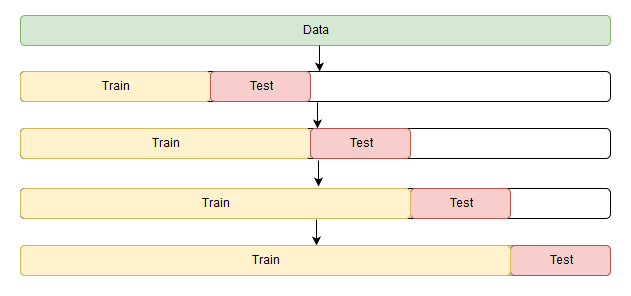

In [824]:
# Создадим функцию для пременения способа GridSearchCV для нахождения и сохранения лучших параметров модели
def best_parameters(Regressor,features,target,param):
    model = GridSearchCV(estimator=Regressor, param_grid=param, cv=tscv,n_jobs=-1)
    model.fit(features, target)
    display(f'Лучшие параметры: {model.best_params_}')
    return model.best_estimator_

In [825]:
# Запишем параметры,которые мы хотим перебрать для разных моделей в отдельные переменные 
param_tree = {'max_depth': range(1, 20),
          'min_samples_split': range(2, 40, 10), 
          'min_samples_leaf': range(1, 20, 5)}
param_forest = {'n_estimators': range(10, 100, 10),
                'max_depth': range(1,11,2),
                'min_samples_leaf':range(2,6,2)}
param_linear = {}
param_LGBM = {'max_depth': range(2,11,2),
              'num_leaves':range(10,70,10),
              'learning_rate':[0.1,0.2],
              'n_estimators' : [100,200,300]}

param_catboost = {'depth': range(2,11,2),
                  'learning_rate':[0.1,0.2,0.5],
                  'iterations':[80,100,200]}

<div style="border:solid gray 2px; padding: 20px">
    
<font color='brown'>В ходе разделения наших данных на выборки мы получили обучающую выборку - 90% и тестовую - 10%. Количество записей в признаках составило 3805 и столбцов 27, Выборки с целевыми признаками составили 423 записей. Так же был использован метод  TimeSeriesSplit для того, чтобы не перемешивать выборки. Cтандартизация методом StandardScaler не помогла улучшить данные. Создали функцию для преминения способа GridSearchCV для нахождения и сохранения лучших параметров модели.

<a href='#0.0'>Содержание'</a>

### 3.2 Подбор гиперпараметров  <a id='1.8'></a>

In [826]:
display('Модель LinearRegression:')
ln_model = best_parameters(LinearRegression(),features_train,target_train,param_linear)
pred = ln_model.predict(features_train)
display(f'Метрики качества модели RMSE:{rmse(target_train, pred)}')

'Модель LinearRegression:'

'Лучшие параметры: {}'

'Метрики качества модели RMSE:28.787131604466275'

In [827]:
display('Модель CatBoostRegressor:')
catboost_model = best_parameters(CatBoostRegressor(loss_function = 'RMSE',random_state = rs,verbose = False),
                                 features_train,target_train,param_catboost)
pred = catboost_model.predict(features_train)
display(f'Метрики качества модели RMSE:{rmse(target_train, pred)}')

'Модель CatBoostRegressor:'

"Лучшие параметры: {'depth': 6, 'iterations': 200, 'learning_rate': 0.1}"

'Метрики качества модели RMSE:15.693741402376826'

In [828]:
display('Модель DecisionTreeRegressor:')
tree_model = best_parameters(DecisionTreeRegressor(random_state=rs),features_train,target_train,param_tree)
pred = tree_model.predict(features_train)
display(f'Метрики качества модели RMSE:{rmse(target_train, pred)}')

'Модель DecisionTreeRegressor:'

"Лучшие параметры: {'max_depth': 10, 'min_samples_leaf': 16, 'min_samples_split': 2}"

'Метрики качества модели RMSE:20.473609467713484'

In [829]:
display('Модель RandomForestRegressor:')
forest_model = best_parameters(RandomForestRegressor(random_state=rs),features_train,target_train,param_forest)
pred = forest_model.predict(features_train)
display(f'Метрики качества модели RMSE:{rmse(target_train, pred)}')

'Модель RandomForestRegressor:'

"Лучшие параметры: {'max_depth': 9, 'min_samples_leaf': 2, 'n_estimators': 60}"

'Метрики качества модели RMSE:15.995101404599957'

In [830]:
display('Модель LGBMRegressor:')
LGBM_model = best_parameters(LGBMRegressor(random_state=rs),features_train,target_train,param_LGBM)
pred = LGBM_model.predict(features_train)
display(f'Метрики качества модели RMSE:{rmse(target_train, pred)}')

'Модель LGBMRegressor:'

"Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'num_leaves': 20}"

'Метрики качества модели RMSE:17.150329241012244'

<div style="border:solid gray 2px; padding: 20px">
    
<font color='brown'> В исследовании применяли 5 моделей: Решающего дерева, Случайного леса, Линейной регрессии, CatBoostRegressor и LGBMRegressor.
- Метрика качества RMSE для модели Линейной регрессии на обучающей выборке составила 28.78 заказов.
- Метрика качества RMSE для модели Решающее дерево на обучающей выборке составила 20.47 заказов.
- Метрика качества RMSE для модели Случайного леса на обучающей выборке составила 15.99 заказов.
- Метрика качества RMSE для модели CatBoostRegressor на обучающей выборке составила 15.69 заказов.
- Метрика качества RMSE для модели LGBMRegressor на обучающей выборке составила 17.15 заказов.

<a href='#0.0'>Содержание'</a>

# 4. Тестирование <a id='1.9'></a>

In [831]:
# проверим на адекватность - Спрогнозировать временные ряды без обучения можно двумя способами:
# Первый способ - Все значения тестовой выборки предсказываются одним и тем же числом (константой). Для метрики MAE — это медиана.
pred_median = np.ones(target_test.shape) * target_train.median()
rmse_const = mean_squared_error(target_test, pred_median) ** 0.5
rmse_const

76.26175838493481

In [832]:
# Второй способ - Новое значение x(t) прогнозируется предыдущим значением ряда, то есть x(t-1). Этот способ не зависит от метрики.
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]
rmse_prev = mean_squared_error(target_test, pred_previous) ** 0.5
rmse_prev

50.613563997411745

In [833]:
pred_test = catboost_model.predict(features_test)
display(f'Метрики качества модели RMSE на тестовой выборке:{rmse(target_test, pred_test)}')

'Метрики качества модели RMSE на тестовой выборке:36.0921288840266'

<AxesSubplot:xlabel='datetime'>

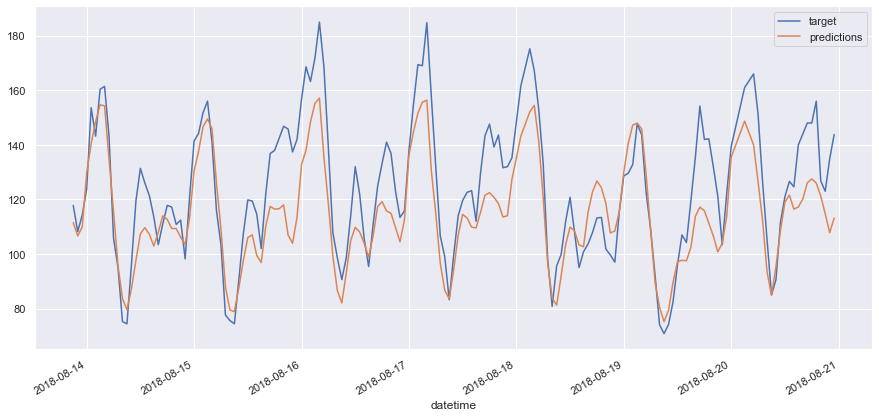

In [834]:
pred = pd.DataFrame(index = target_test.index)
pred['target'] = target_test
pred['predictions'] = pred_test
pred['2018-08-13' : '2018-08-20'].rolling(5).mean().plot(figsize=(15, 7))

<div style="border:solid gray 2px; padding: 20px">
    
<font color='brown'> В ходе тестирования проделали следующее:
 - Создали константную модели для проверки на адекватность. Все значения тестовой выборки предсказываются одним и тем же числом (константой) — это медиана. Метрика качества модели RMSE: 76.26 заказов.
 - Создали константную модели для проверки на адекватность. Новое значение x(t) прогнозируется предыдущим значением ряда, то есть x(t-1). Этот способ не зависит от метрики. Метрика качества модели RMSE: 50.61 заказов. 
 - Протестировали лучшую модель CatBoostRegressor, которая показала метрику качества модели RMSE на тестовой выборке равной 36.09 заказов.
 - Сравнили истинные и предсказанные значения. Как видно по графику, наша модель достаточно хорошо попадает в реальные заказы. Можно еще улучшить результат при более тщательном подборе гиперпараметров.

<a href='#0.0'>Содержание'</a>

# Выводы <a id='2.0'></a>

Была построена модель для прогноза количества заказов такси на следующий час. Для этого данные были ресемплированы по одному часу и проанализированы, а так же выделена однодневная и недельная сезонность.

Был определен тренд на увеличение числа заказов с течением времени, тренд на повышение - это может быть, как годовая сезонность, так и рост числа заказов из-за увеличения количества клиентов(компания привлекла больше клиентов в связи с увеличением автопарка, либо проведения акций или увеличения расходов на рекламу, т.е. не за счет сезонности. Отчетливо прослеживается сезонная зависимость количества заказов от дня недели.

В течении недели: С понедельника по вторник наблюдается спад заказов, в среду наблюдаем рост заказов, в четверг снова спад заказов и с пятницы по воскресенье наблюдается рост заказов. Всего 4 взлета и падения.

В течении суток: С 12 ночи до 6 утра видим спад заказов, с 6 утра до 10 утра рост заказов, затем до 12 дня падение числа заказов и с 12 часов до 16 идет рост, с 16 до 18 - падение и с 18 до 12 часов снова рост заказов. Всего 6 падение и взлетов. 

Были созданы 4 календарных признака (месяц,день недели, день, час). Были созданы 24 признака отстающих значений, max_lag был взят как 24 часа. Был создан 1 признака скользящего среднего, с шириной окна = 168 (за неделю в часах).

Удалим коррелирующие признаки и удалим выбросы свыше 250 за час.

В ходе разделения наших данных на выборки мы получили обучающую выборку - 90% и тестовую - 10%. 

В исследовании применяли 5 моделей: Решающего дерева, Случайного леса, Линейной регрессии, CatBoostRegressor и LGBMRegressor.
- Метрика качества RMSE для модели Линейной регрессии на обучающей выборке составила 28.78 заказов.
- Метрика качества RMSE для модели Решающее дерево на обучающей выборке составила 20.47 заказов.
- Метрика качества RMSE для модели Случайного леса на обучающей выборке составила 15.99 заказов.
- Метрика качества RMSE для модели CatBoostRegressor на обучающей выборке составила 15.69 заказов.
- Метрика качества RMSE для модели LGBMRegressor на обучающей выборке составила 17.15 заказов.

- Создали константную модели для проверки на адекватность. Все значения тестовой выборки предсказываются одним и тем же числом (константой) — это медиана. Метрика качества модели RMSE: 76.26 заказов.
- Создали константную модели для проверки на адекватность. Новое значение x(t) прогнозируется предыдущим значением ряда, то есть x(t-1). Этот способ не зависит от метрики. Метрика качества модели RMSE: 50.61 заказов. 
- Протестировали лучшую модель CatBoostRegressor, которая показала метрику качества модели RMSE на тестовой выборке равной 36.09 заказов.
- Сравнили истинные и предсказанные значения. Как видно по графику, наша модель достаточно хорошо попадает в реальные заказы. Можно еще улучшить результат при более тщательном подборе гиперпараметров.

### В итоге мы получили лучшую модель CatBoostRegressor, которая показала метрику качества модели RMSE на тестовой выборке равной 36.09 заказов. Т.е. построеная модель для прогноза количества заказов такси на следующий час будет ошибаться в среднем на 36 заказов

# Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Данные проанализированы
- [ ]  Модель обучена, гиперпараметры подобраны
- [ ]  Качество моделей проверено, выводы сделаны
- [ ]  Значение *RMSE* на тестовой выборке не больше 48